# XGBoost models informed by feature selection analysis (using all data)

Door to needle time: For the scenarios (apart from actual scenario), all patients use 30 minutes door to needle time.

### Plain English summary

Use a model equivalent to the one trained in notebook 040 (but for this one use all data to train the model, and no test set) to calculate the multiclass mRS distributions (individual mRS + cumulative distributions + weighted mRS) for all of the patients in the population with/without thrombolysis (Assume no-one on AFIb anticoagulant would receive thrombolysis - so remove these from the population and report the number removed).

The model includes 7 features: ["prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known"]

How would outcomes compare using:
1. actual decision made
1. benchmark
1. 'best outcome'

### Model and data
XGBoost\
7 features: ["prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known"]\
All data (not use kfolds)

Population to train IVT decision model:
* Just ischaemic.
* No anticolgalents
* No thrombectomy patients.


### Aims

### Observations


#### Further work

#### Resources
pip install plotly
pip install dash

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
#import plotly.express as px

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import math

import importlib
# Import local package
#from utils import waterfall
## Force package to be reloaded
#importlib.reload(waterfall);

# Need for cm subplots?
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib.colors import LogNorm
#from matplotlib.ticker import MultipleLocator

#pip install category_encoders
#import category_encoders as ce

#import dash_core_components as dcc
#from dash import dcc
#import plotly.express as px
#import plotly.subplots as sp
#from plotly.offline import plot
#from plotly.subplots import make_subplots

import time

Report the time duration to run notebook

In [2]:
start_time = time.time()

In [3]:
# For those patients that do not get thrombolysis, the onset to thrombolysis time to calculate their outcome had they been given thrombolysis
ott_default = 120

Select the features for the model for disability discharge

In [4]:
selected_features_mrs = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known", "discharge_disability"]

Select the features for the model for treatment

In [5]:
selected_features_treatment = ["prior_disability", "stroke_severity", 
                     "age", "arrival_to_scan_time", "precise_onset_known", 
                     "onset_to_arrival_time","onset_during_sleep", 
                     "stroke_team", "S2Thrombolysis"]

Get union of both sets of features

In [6]:
selected_features_set = list(set.union(set(selected_features_mrs), 
                                       set(selected_features_treatment)))

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [7]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output'
    model_text: str = 'xgb_all_data_multiclass_outcome'
    notebook: str = '211_'

paths = Paths()

Create output folders if needed

In [8]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [9]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, '02_reformatted_data_ml.csv')
data = pd.read_csv(filename)

Keep only patients not taking AF anticoagulants (dataset already only includes patients that have an infarction)

In [10]:
data = data[data["afib_anticoagulant"] == 0].reset_index()

Store number of patients

In [11]:
n_patients = data.shape[0]

# Create new features

### 1. Create new feature "S2Thrombolysis" from the surrogate "scan_to_thrombolysis_time"

In [12]:
mask_treated = data["scan_to_thrombolysis_time"] >- 100
mask_not_treated = data["scan_to_thrombolysis_time"] == -100
data["S2Thrombolysis"] = mask_treated

### 2. All patients have 30 mins door to needle time

In [13]:
onset_to_thrombolysis_time_all_treated_30mins_d2n = (
    data["onset_to_arrival_time"] + data["arrival_to_scan_time"] + 30)

Store in dataframe

In [14]:
data["onset_to_thrombolysis_time"] = onset_to_thrombolysis_time_all_treated_30mins_d2n.copy(deep=True)
data["onset_to_thrombolysis_time"][mask_not_treated] = -100

#### Select features to use in  both models

In [15]:
data = data[selected_features_set]

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [16]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [17]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [18]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features_set:
        data = convert_feature_to_one_hot(data, feature, prefix)

Feature names with one hot encoding

In [19]:
feature_names_ohe = list(data)

Extract the team names

In [20]:
ohe_stroke_team_features = [col for col in feature_names_ohe if col.startswith('team')]

Update the feature names to use in the model (remove "stroke_team" and add in all the one hot encoded feature names)

In [21]:
# replace the column name "stroke_team" with the ohe column names
selected_features_mrs.remove("stroke_team")
selected_features_mrs = selected_features_mrs + ohe_stroke_team_features

# replace the column name "stroke_team" with the ohe column names
selected_features_treatment.remove("stroke_team")
selected_features_treatment = selected_features_treatment + ohe_stroke_team_features

# Discharge disability outcome multiclass model

Get data for features for the outcome model

In [22]:
data_outcome = data[selected_features_mrs]

In [23]:
feature_names_ohe = list(data_outcome)
feature_names_ohe.remove("discharge_disability")
n_features_ohe = len(feature_names_ohe)

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (disability discharge) `y`.

In [24]:
X_outcome = data_outcome.drop('discharge_disability', axis=1)
y_outcome = data_outcome['discharge_disability']

## Fit XGBoost model multiclass classification model for discharge disability

Load model from notebook 210

In [25]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                ('210_' + paths.model_text + '.p'))

# Check if exists
file_exists = exists(filename)

if file_exists:
# Load models
    with open(filename, 'rb') as filehandler:
        model_outcome = pickle.load(filehandler)
else:
    # Print warning message
    print("Run notebook 210, trains the model")

Define function to calculate the population outcome (from the individual patient mRS probabilities)

In [26]:
def calculate_population_outcome(y_probs, mrs_classes):
    weighted_mrs = (y_probs * mrs_classes).sum(axis=1)
    return(np.average(weighted_mrs),weighted_mrs)

Extract the classes from the multiclass model

In [27]:
mrs_classes = model_outcome.classes_

# Run scenarios 8 scenarios

## 1. Scenario: All patients are treated

In [28]:
# Create X data for all treated
X_all_treated = data_outcome.drop('discharge_disability', axis=1)
X_all_treated["onset_to_thrombolysis_time"] = (
                              onset_to_thrombolysis_time_all_treated_30mins_d2n)

# Calculate and store predicted outcome probabilities
y_outcome_probs_all_treated = model_outcome.predict_proba(X_all_treated)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_all_treated, weighted_mrs_all_treated) = (
        calculate_population_outcome(y_outcome_probs_all_treated, mrs_classes))

mask_all_treated = X_all_treated["onset_to_thrombolysis_time"] > -100

## 2. Scenario: No patients are treated

In [29]:
# Create X data for none treated
X_none_treated = data_outcome.drop('discharge_disability', axis=1)
X_none_treated["onset_to_thrombolysis_time"] = -100

# Calculate and store predicted outcome probabilities
y_outcome_probs_none_treated = model_outcome.predict_proba(X_none_treated)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_none_treated, weighted_mrs_none_treated) = (
    calculate_population_outcome(y_outcome_probs_none_treated, mrs_classes))

mask_none_treated = X_none_treated["onset_to_thrombolysis_time"] > -100

## 3. Scenario: Actual treatment decision

In [30]:
# Calculate and store predicted outcome probabilities
y_outcome_probs = model_outcome.predict_proba(X_outcome)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_actual_treatment, weighted_mrs_actual_treatment) = (
                    calculate_population_outcome(y_outcome_probs, mrs_classes))

mask_actual_treatment = X_outcome["onset_to_thrombolysis_time"] > -100

## 4. Scenario: Benchmark treatment decision

Read in the 25 benchmark hospitals (identified in notebook 200)

In [31]:
filename = os.path.join(paths.data_save_path, 
    ('200_xgb_10_features_all_data_thrombolysis_decision_highest_25_benchmark_'
     'hospitals_median_shap.csv'))

benchmark_hospitals = pd.read_csv(filename)
benchmark_hospitals = list(benchmark_hospitals['hospital'])

In [32]:
# Open model to get thrombolysis decision based on benchmark hospitals

# Model filename
filename_treatment_model = os.path.join(paths.model_save_path, 
                '200_xgb_10_features_all_data_thrombolysis_decision.p')

# Check if exists
file_exists = exists(filename_treatment_model)

if file_exists:
# Load models
    with open(filename_treatment_model, 'rb') as filehandler:
        model_treatment_decision = pickle.load(filehandler)
else:
    # give warning message
    print("Run notebook 200 to fit the treatment decision model")

In [33]:
# Get dataset for the treatment decision model
data_treatment_decision = data[selected_features_treatment]
X_treatment_decision = data_treatment_decision.drop('S2Thrombolysis', axis=1)

# Initialise dataframe to store benchmark hospital retults
df_benchmark_decisions = pd.DataFrame()

# For each benchmark hosptial, send all patients there, get treatment decision
for h in benchmark_hospitals:
    X_treatment_decision[ohe_stroke_team_features] = 0
    X_treatment_decision[f"team_{h}"] = 1
    df_benchmark_decisions[f"{h}"] = (
                    model_treatment_decision.predict(X_treatment_decision))

# Calculate the majority vote from the 25 benchmark hosptials
mask_benchmark_decision = df_benchmark_decisions.sum(axis=1) > (25/2)

Use the benchmark decision whether to treat each patient

In [34]:
X_outcome_benchmark_decision = X_outcome.copy(deep=True)

# Set all patients as having thrombolysis, then set those that benchmark not 
# give as -100
X_outcome_benchmark_decision["onset_to_thrombolysis_time"] = (
                            onset_to_thrombolysis_time_all_treated_30mins_d2n)
mask_benchmark_not_treat = mask_benchmark_decision == 0
X_outcome_benchmark_decision["onset_to_thrombolysis_time"][mask_benchmark_not_treat] = -100

Calculate the population outcome for the scenario

In [35]:
# Calculate and store predicted outcome probabilities
y_outcome_probs_benchmark = model_outcome.predict_proba(
                                                X_outcome_benchmark_decision)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_benchmark, weighted_mrs_benchmark) = (
        calculate_population_outcome(y_outcome_probs_benchmark, mrs_classes))

## 5. Scenario: Best outcome decision

In [36]:
weighted_mrs_best_outcome = np.minimum(weighted_mrs_all_treated, 
                                   weighted_mrs_none_treated)
mask_best_outcome = weighted_mrs_all_treated < weighted_mrs_none_treated
ave_weighted_mrs_best_outcome = np.average(weighted_mrs_best_outcome)

## 6. Scenario: Worst outcome decision

In [37]:
weighted_mrs_worst_outcome = np.maximum(weighted_mrs_all_treated, 
                                    weighted_mrs_none_treated)
mask_worst_outcome = weighted_mrs_all_treated > weighted_mrs_none_treated
ave_weighted_mrs_worst_outcome = np.average(weighted_mrs_worst_outcome)

Store number of patients with indifferent outcome (in terms of weighted mRS) based on treatment

In [38]:
mask_weighted_mrs_indifferent_outcome = (
                    weighted_mrs_all_treated == weighted_mrs_none_treated)

## 7. Scenario: Best likelihood of being mRS 0-4

In [39]:
# Calculate the likelihood of being mRS0 to 4 with and without treatment
proportion_mrs0_to_4_all_treated = y_outcome_probs_all_treated[:,0:5].sum(axis=1)
proportion_mrs0_to_4_not_treated = y_outcome_probs_none_treated[:,0:5].sum(axis=1)

# Store best treatment option (treated or not)
mask_best_proportion = (
            proportion_mrs0_to_4_all_treated > proportion_mrs0_to_4_not_treated)

# Store patient weighted mRS based on treatment choice from best likelihood 
# being mRS0 to 4
weighted_mrs_best_proportion = copy.deepcopy(weighted_mrs_none_treated)
weighted_mrs_best_proportion[mask_best_proportion] = (
                            weighted_mrs_all_treated[mask_best_proportion])

# Population outcome
ave_weighted_mrs_best_proportion = np.average(weighted_mrs_best_proportion)

## 8. Scenario: Worst likelihood of being mRS 0-4

In [40]:
# Store best treatment option (treated or not)
mask_worst_proportion = (
            proportion_mrs0_to_4_all_treated < proportion_mrs0_to_4_not_treated)


# Store patient weighted mRS based on treatment choice from worst likelihood 
# being mRS0 to 4
weighted_mrs_worst_proportion = copy.deepcopy(weighted_mrs_none_treated)
weighted_mrs_worst_proportion[mask_worst_proportion] = (
                            weighted_mrs_all_treated[mask_worst_proportion])

# Population outcome
ave_weighted_mrs_worst_proportion = np.average(weighted_mrs_worst_proportion)

Store patients with indifferent outcome (in terms of likelihood of being mRS 0 - 4) based on treatment

In [41]:
mask_weighted_mrs_indifferent_proportion = (
    proportion_mrs0_to_4_all_treated == proportion_mrs0_to_4_not_treated)

### 9. Scenario: Best weighted mRS and best likelihood of being mRS 0-4

In [42]:
mask_best_outcome_and_proportion = mask_best_outcome * mask_best_proportion

# Store patient weighted mRS based on treatment choice from best likelihood 
# being mRS0 to 4 AND best weighted outcome
weighted_mrs_best_outcome_and_proportion = copy.deepcopy(weighted_mrs_none_treated)
weighted_mrs_best_outcome_and_proportion[mask_best_outcome_and_proportion] = (
                            weighted_mrs_all_treated[mask_best_outcome_and_proportion])

# Population outcome
ave_weighted_mrs_best_outcome_and_proportion = np.average(weighted_mrs_best_outcome_and_proportion)

### 10. Scenario: Worse weighted mRS and worse likelihood of being mRS 0-4

In [43]:
mask_worst_outcome_and_proportion = mask_worst_outcome * mask_worst_proportion

# Store patient weighted mRS based on treatment choice from best likelihood 
# being mRS0 to 4 AND best weighted outcome
weighted_mrs_worst_outcome_and_proportion = copy.deepcopy(weighted_mrs_none_treated)
weighted_mrs_worst_outcome_and_proportion[mask_worst_outcome_and_proportion] = (
                     weighted_mrs_all_treated[mask_worst_outcome_and_proportion])

# Population outcome
ave_weighted_mrs_worst_outcome_and_proportion = np.average(weighted_mrs_worst_outcome_and_proportion)

Initialise dataframe to store which patients got treatment in each scenario 

In [44]:
df_treatment_decision_per_scenario = pd.DataFrame()

df_treatment_decision_per_scenario["All_treated"] = mask_all_treated * 1
df_treatment_decision_per_scenario["None_treated"] = mask_none_treated * 1
df_treatment_decision_per_scenario["Actual_treatment_decision"] = mask_actual_treatment * 1
df_treatment_decision_per_scenario["Benchmark_treatment_decision"] = mask_benchmark_decision * 1
df_treatment_decision_per_scenario["Best_weighted_outcome"] = mask_best_outcome * 1
df_treatment_decision_per_scenario["Worst_weighted_outcome"] = mask_worst_outcome * 1
df_treatment_decision_per_scenario["Best_proportion_outcome"] = mask_best_proportion * 1
df_treatment_decision_per_scenario["Worst_proportion_outcome"] = mask_worst_proportion * 1
df_treatment_decision_per_scenario["Best_weighted_outcome_and_proportion_outcome"] = mask_best_outcome_and_proportion * 1
df_treatment_decision_per_scenario["Worst_weighted_outcome_and_proportion_outcome"] = mask_worst_outcome_and_proportion * 1


In [45]:
df_treatment_decision_per_scenario.describe()

,All_treated,None_treated,Actual_treatment_decision,Benchmark_treatment_decision,Best_weighted_outcome,Worst_weighted_outcome,Best_proportion_outcome,Worst_proportion_outcome,Best_weighted_outcome_and_proportion_outcome,Worst_weighted_outcome_and_proportion_outcome
count,146705.0,146705.0,146705.000000,146705.000000,146705.000000,146705.000000,146705.000000,146705.000000,146705.000000,146705.000000
mean,1.0,0.0,0.229481,0.318278,0.656658,0.342606,0.595488,0.403776,0.499826,0.246945
std,0.0,0.0,0.420500,0.465810,0.474826,0.474583,0.490799,0.490655,0.500002,0.431236
min,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.0,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Save results to file

In [46]:
# Model filename
filename = os.path.join(paths.data_save_path, 
                (paths.notebook + paths.model_text + '_scenario_treatment_decision_results.csv'))

df_treatment_decision_per_scenario.to_csv(filename)

Initialise dataframe to store patients mrs probabilites in each scenario 

In [47]:
df_weighted_mrs_per_scenario = pd.DataFrame()

df_weighted_mrs_per_scenario["All_treated"] = weighted_mrs_all_treated 
df_weighted_mrs_per_scenario["None_treated"] = weighted_mrs_none_treated
df_weighted_mrs_per_scenario["Actual_treatment_decision"] = weighted_mrs_actual_treatment
df_weighted_mrs_per_scenario["Benchmark_treatment_decision"] = weighted_mrs_benchmark
df_weighted_mrs_per_scenario["Best_weighted_outcome"] = weighted_mrs_best_outcome
df_weighted_mrs_per_scenario["Worst_weighted_outcome"] = weighted_mrs_worst_outcome
df_weighted_mrs_per_scenario["Best_proportion_outcome"] = weighted_mrs_best_proportion
df_weighted_mrs_per_scenario["Worst_proportion_outcome"] = weighted_mrs_worst_proportion
df_weighted_mrs_per_scenario["Best_weighted_outcome_and_proportion_outcome"] = weighted_mrs_best_outcome_and_proportion * 1
df_weighted_mrs_per_scenario["Worst_weighted_outcome_and_proportion_outcome"] = weighted_mrs_worst_outcome_and_proportion * 1

In [48]:
df_weighted_mrs_per_scenario.describe()

,All_treated,None_treated,Actual_treatment_decision,Benchmark_treatment_decision,Best_weighted_outcome,Worst_weighted_outcome,Best_proportion_outcome,Worst_proportion_outcome,Best_weighted_outcome_and_proportion_outcome,Worst_weighted_outcome_and_proportion_outcome
count,146705.000000,146705.000000,146705.000000,146705.000000,146705.000000,146705.000000,146705.000000,146705.000000,146705.000000,146705.000000
mean,2.505877,2.645826,2.551815,2.520693,2.428274,2.723428,2.469509,2.682193,2.451574,2.705492
std,1.286900,1.364623,1.342935,1.334584,1.296632,1.342866,1.282627,1.363947,1.288439,1.351792
min,0.139681,0.163118,0.154213,0.154019,0.139681,0.196767,0.139681,0.164013,0.139681,0.196767
25%,1.485606,1.535843,1.477039,1.454400,1.396386,1.644904,1.448435,1.578954,1.426538,1.614751
50%,2.172886,2.284752,2.180206,2.144659,2.060854,2.380406,2.129978,2.322670,2.094724,2.347490
75%,3.407834,3.649978,3.500203,3.459981,3.346453,3.717879,3.364363,3.701946,3.361118,3.715692
max,5.955374,5.952412,5.952412,5.952412,5.940068,5.955374,5.943656,5.955374,5.940068,5.955374


Save results to file

In [49]:
# Model filename
filename = os.path.join(paths.data_save_path, 
    (paths.notebook + paths.model_text + '_scenario_weighted_mrs_results.csv'))

df_weighted_mrs_per_scenario.to_csv(filename)

Patients for who treatment not change their weighted mRS

In [50]:
mask_weighted_mrs_indifferent_outcome.sum()

108

Patients for who treatment not change their likelihood being mRS0-4

In [51]:
mask_weighted_mrs_indifferent_proportion.sum()

108

# Questions to ask of the data

## Question 1. Is it largely an effect of stroke severity?

Would be expect to see a bigger shift in patient outcome with the more severe strokes?

Most of the strokes are mild severity. Expect that they will be receiving the least effect from thrombolysis treatment. This will weight the population outcome to appear as a smaller effect.

If look just at subgroups of patients (say, moderate strokes, or severe stroke with no prior disability) we may see a larger effect.

Look at results for subgroups of patients

### 1. Subgroup: Patients with mild stroke

In [52]:
mask_mild = data["stroke_severity"] < 5

df_treatment_per_scenario_mild_stroke = (
    df_treatment_decision_per_scenario[mask_mild])

df_treatment_per_scenario_mild_stroke.describe()

,All_treated,None_treated,Actual_treatment_decision,Benchmark_treatment_decision,Best_weighted_outcome,Worst_weighted_outcome,Best_proportion_outcome,Worst_proportion_outcome,Best_weighted_outcome_and_proportion_outcome,Worst_weighted_outcome_and_proportion_outcome
count,72448.0,72448.0,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000
mean,1.0,0.0,0.085606,0.103633,0.458467,0.540954,0.374365,0.625055,0.236100,0.402689
std,0.0,0.0,0.279784,0.304786,0.498275,0.498323,0.483962,0.484112,0.424688,0.490443
min,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.0,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
df_weighted_mrs_per_scenario_mild_stroke = (
    df_weighted_mrs_per_scenario[mask_mild])
df_weighted_mrs_per_scenario_mild_stroke.describe()

,All_treated,None_treated,Actual_treatment_decision,Benchmark_treatment_decision,Best_weighted_outcome,Worst_weighted_outcome,Best_proportion_outcome,Worst_proportion_outcome,Best_weighted_outcome_and_proportion_outcome,Worst_weighted_outcome_and_proportion_outcome
count,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000
mean,1.848877,1.796715,1.784630,1.780143,1.721488,1.924104,1.779055,1.866538,1.750254,1.895303
std,0.874151,0.838923,0.843864,0.845276,0.842704,0.859428,0.841908,0.869861,0.838825,0.861273
min,0.139681,0.163118,0.154213,0.154019,0.139681,0.196767,0.139681,0.164013,0.139681,0.196767
25%,1.244124,1.234218,1.217442,1.212978,1.159026,1.337793,1.207771,1.273899,1.189560,1.310320
50%,1.644007,1.597389,1.580201,1.572830,1.508598,1.731385,1.578922,1.659322,1.543724,1.693512
75%,2.281518,2.173288,2.166193,2.162722,2.093894,2.341485,2.180160,2.270264,2.122925,2.291571
max,5.620250,5.509942,5.509942,5.509942,5.435390,5.620250,5.438134,5.620250,5.435390,5.620250


### 2. Subgroup: Patients with moderate stroke

In [56]:
mask_moderate = (data["stroke_severity"] > 4) & (data["stroke_severity"] < 21)

df_treatment_per_scenario_moderate_stroke = (
    df_treatment_decision_per_scenario[mask_moderate])

df_treatment_per_scenario_mild_stroke.describe()

,All_treated,None_treated,Actual_treatment_decision,Benchmark_treatment_decision,Best_weighted_outcome,Worst_weighted_outcome,Best_proportion_outcome,Worst_proportion_outcome,Best_weighted_outcome_and_proportion_outcome,Worst_weighted_outcome_and_proportion_outcome
count,72448.0,72448.0,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000,72448.000000
mean,1.0,0.0,0.085606,0.103633,0.458467,0.540954,0.374365,0.625055,0.236100,0.402689
std,0.0,0.0,0.279784,0.304786,0.498275,0.498323,0.483962,0.484112,0.424688,0.490443
min,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.0,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
df_weighted_mrs_per_scenario_mild_stroke = (
    df_weighted_mrs_per_scenario[mask_moderate])
df_weighted_mrs_per_scenario_mild_stroke.describe()

,All_treated,None_treated,Actual_treatment_decision,Benchmark_treatment_decision,Best_weighted_outcome,Worst_weighted_outcome,Best_proportion_outcome,Worst_proportion_outcome,Best_weighted_outcome_and_proportion_outcome,Worst_weighted_outcome_and_proportion_outcome
count,63023.000000,63023.000000,63023.000000,63023.000000,63023.000000,63023.000000,63023.000000,63023.000000,63023.000000,63023.000000
mean,2.862250,3.178726,3.004996,2.947385,2.830806,3.210169,2.859241,3.181735,2.851241,3.202169
std,1.170443,1.124576,1.175061,1.186930,1.152702,1.133139,1.144195,1.150435,1.146139,1.137573
min,0.244093,0.381130,0.244093,0.244093,0.244093,0.381130,0.244093,0.308257,0.244093,0.381130
25%,1.894558,2.236077,2.037173,1.963302,1.874760,2.262149,1.922453,2.216513,1.911521,2.246369
50%,2.735514,3.108414,2.889292,2.827505,2.704238,3.131791,2.740498,3.105611,2.726650,3.127622
75%,3.781096,4.122975,3.963347,3.909987,3.744457,4.163643,3.759830,4.154713,3.757977,4.162753
max,5.898032,5.891461,5.891461,5.891461,5.859742,5.898032,5.859742,5.898032,5.859742,5.898032


### 3. Subgroup: Patients with severe stroke

In [58]:
mask_severe = data["stroke_severity"] > 20

df_treatment_per_scenario_severe_stroke_no_prior_disability = (
    df_treatment_decision_per_scenario[mask_severe])

df_treatment_per_scenario_severe_stroke_no_prior_disability.describe()

,All_treated,None_treated,Actual_treatment_decision,Benchmark_treatment_decision,Best_weighted_outcome,Worst_weighted_outcome,Best_proportion_outcome,Worst_proportion_outcome,Best_weighted_outcome_and_proportion_outcome,Worst_weighted_outcome_and_proportion_outcome
count,11234.0,11234.0,11234.000000,11234.000000,11234.000000,11234.000000,11234.000000,11234.00000,11234.000000,11234.000000
mean,1.0,0.0,0.354282,0.472672,0.889265,0.110201,0.906356,0.09311,0.861047,0.064892
std,0.0,0.0,0.478316,0.499275,0.313818,0.313154,0.291346,0.29060,0.345913,0.246347
min,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.0,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000
50%,1.0,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000
75%,1.0,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000
max,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [59]:
df_weighted_mrs_per_scenario_severe_stroke_no_prior_disability = (
    df_weighted_mrs_per_scenario[mask_severe])

df_weighted_mrs_per_scenario_severe_stroke_no_prior_disability.describe()

,All_treated,None_treated,Actual_treatment_decision,Benchmark_treatment_decision,Best_weighted_outcome,Worst_weighted_outcome,Best_proportion_outcome,Worst_proportion_outcome,Best_weighted_outcome_and_proportion_outcome,Worst_weighted_outcome_and_proportion_outcome
count,11234.000000,11234.000000,11234.000000,11234.000000,11234.000000,11234.000000,11234.000000,11234.000000,11234.000000,11234.000000
mean,4.743598,5.132156,4.957026,4.902747,4.728120,5.147634,4.735844,5.139910,4.732240,5.144029
std,0.714417,0.510173,0.693027,0.718487,0.708395,0.506296,0.710939,0.509006,0.708764,0.506178
min,1.323733,2.067414,1.634676,1.323733,1.323733,2.256282,1.323733,2.067414,1.323733,2.067414
25%,4.331866,4.887118,4.609960,4.526491,4.319340,4.902055,4.324319,4.897418,4.321478,4.900800
50%,4.921173,5.275546,5.188340,5.129744,4.907789,5.290875,4.912808,5.280310,4.912199,5.284833
75%,5.276707,5.495580,5.459025,5.436986,5.261299,5.509254,5.272968,5.502298,5.266687,5.503599
max,5.955374,5.952412,5.952412,5.952412,5.940068,5.955374,5.943656,5.955374,5.940068,5.955374


### 4. Subgroup: Patients with severe stroke with no prior disability

In [60]:
mask_no_prior_disability = data["prior_disability"] <2

df_treatment_per_scenario_severe_stroke_no_prior_disability = (
    df_treatment_decision_per_scenario[mask_severe * mask_no_prior_disability])

df_treatment_per_scenario_severe_stroke_no_prior_disability.describe()

,All_treated,None_treated,Actual_treatment_decision,Benchmark_treatment_decision,Best_weighted_outcome,Worst_weighted_outcome,Best_proportion_outcome,Worst_proportion_outcome,Best_weighted_outcome_and_proportion_outcome,Worst_weighted_outcome_and_proportion_outcome
count,5377.0,5377.0,5377.000000,5377.000000,5377.000000,5377.000000,5377.000000,5377.000000,5377.000000,5377.000000
mean,1.0,0.0,0.474986,0.622466,0.928957,0.070299,0.914078,0.085178,0.899386,0.055607
std,0.0,0.0,0.499420,0.484815,0.256921,0.255675,0.280274,0.279172,0.300845,0.229183
min,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,1.0,0.0,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,1.0,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
df_weighted_mrs_per_scenario_severe_stroke_no_prior_disability = (
    df_weighted_mrs_per_scenario[mask_severe * mask_no_prior_disability])

df_weighted_mrs_per_scenario_severe_stroke_no_prior_disability.describe()

,All_treated,None_treated,Actual_treatment_decision,Benchmark_treatment_decision,Best_weighted_outcome,Worst_weighted_outcome,Best_proportion_outcome,Worst_proportion_outcome,Best_weighted_outcome_and_proportion_outcome,Worst_weighted_outcome_and_proportion_outcome
count,5377.000000,5377.000000,5377.000000,5377.000000,5377.000000,5377.000000,5377.000000,5377.000000,5377.000000,5377.000000
mean,4.327919,4.873273,4.582425,4.499004,4.314528,4.886664,4.320996,4.880196,4.319584,4.885252
std,0.733375,0.562345,0.766681,0.777900,0.727699,0.556379,0.728777,0.561523,0.729182,0.558342
min,1.323733,2.067414,1.634676,1.323733,1.323733,2.256282,1.323733,2.067414,1.323733,2.067414
25%,3.839333,4.526439,4.094567,3.990595,3.830417,4.540962,3.836847,4.533617,3.834449,4.540962
50%,4.408134,4.961229,4.705117,4.601124,4.391053,4.971051,4.397623,4.965848,4.395504,4.970011
75%,4.880292,5.302486,5.194784,5.107038,4.862345,5.311114,4.866819,5.308301,4.866032,5.310919
max,5.924143,5.952412,5.952412,5.952412,5.905615,5.952412,5.905615,5.952412,5.905615,5.952412


## Question 2: Is there a bigger effect of treatment for patients with a worse predicted outcome without treatment

In [62]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [63]:
# Get r-square of predicted thrombolysis rate.
x_comparision = weighted_mrs_none_treated.reshape(-1, 1)
y_comparision = (weighted_mrs_all_treated - weighted_mrs_none_treated).reshape(-1, 1)

slr = LinearRegression()
slr.fit(x_comparision, y_comparision)
y_pred = slr.predict(x_comparision)
r_square = metrics.r2_score(y_comparision, y_pred)

Text(0, 0.5, 'Difference in weighted mRS when have treatment')

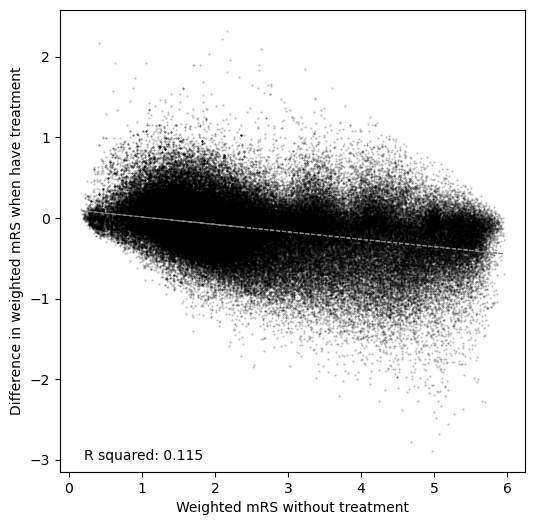

In [64]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(weighted_mrs_none_treated, (weighted_mrs_all_treated - weighted_mrs_none_treated), s=0.2, c="k", alpha=0.3)

plt.plot (x_comparision, slr.predict(x_comparision), color = 'grey', linewidth=0.8, linestyle="--")
text = f'R squared: {r_square:.3f}'
ax1.text(0.2,-3, text, 
         bbox=dict(facecolor='white', edgecolor='white'))

ax1.set_xlabel("Weighted mRS without treatment")
ax1.set_ylabel("Difference in weighted mRS when have treatment")

## Question 3: Which patients are the 108 patients with indifferent outcomes for treatment?

Where's the break even point?

Are the same patients indifferent for both the werighted mRS and the likelihood proportion?

In [65]:
(mask_weighted_mrs_indifferent_outcome == mask_weighted_mrs_indifferent_proportion).sum()/n_patients


1.0

In [66]:
data[mask_weighted_mrs_indifferent_outcome].describe()

,prior_disability,age,stroke_severity,arrival_to_scan_time,onset_to_thrombolysis_time,any_afib_diagnosis,discharge_disability,onset_to_arrival_time,precise_onset_known,onset_during_sleep,...,team_Whiston Hospital HASU,team_William Harvey Hospital,team_Wirral Arrowe Park Hospital,team_Withybush General Hospital,team_Worcestershire Royal Hospital,team_Worthing Hospital,team_Wycombe General Hospital,team_Yeovil District Hospital,team_York Hospital,team_Ysbyty Gwynedd
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,...,108.000000,108.0,108.0,108.0,108.0,108.000000,108.000000,108.000000,108.0,108.0
mean,0.657407,72.592593,8.259259,8.203704,-20.277778,0.092593,2.416667,8.000000,0.685185,0.009259,...,0.009259,0.0,0.0,0.0,0.0,0.018519,0.018519,0.009259,0.0,0.0
std,1.120431,13.688481,6.784218,6.041537,73.185187,0.291212,2.009905,5.789129,0.466607,0.096225,...,0.096225,0.0,0.0,0.0,0.0,0.135445,0.135445,0.096225,0.0,0.0
min,0.000000,37.500000,0.000000,1.000000,-100.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
25%,0.000000,66.250000,3.000000,3.000000,-100.000000,0.000000,1.000000,3.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
50%,0.000000,72.500000,6.500000,8.000000,35.000000,0.000000,2.000000,6.000000,1.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
75%,1.000000,82.500000,13.250000,12.000000,48.000000,0.000000,4.000000,12.000000,1.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
max,4.000000,92.500000,31.000000,24.000000,55.000000,1.000000,6.000000,23.000000,1.000000,1.000000,...,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,0.0


***